# Imports, Variables & Function definitions

In [ ]:



#Imports
import tensorflow as tf
import numpy as np
from keras.datasets import mnist
import foolbox as fb
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from timeit import default_timer as timer


#Variables
epsilon=0.3
batch_size=1024
epochs=1000
pgd_steps=50
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Foolbox version: ", fb.__version__)
tf.config.list_physical_devices('GPU')
np.random.seed(10)
assert tf.__version__=="2.8.0"
assert np.__version__=="1.22.2"
assert fb.__version__=="3.3.1"



#get MNIST data and prepare
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

#define variables needed for attacks
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)

x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)



#Functions
def test_model(model):
    assert epsilon==0.3
    inv_advs_to_test=np.load("invariance_examples/linf/automated_eps03.npy")
    inv_labels_to_test=np.load("invariance_examples/linf/automated_eps03_labels.npy")
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
    attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)

    x_batch,y_batch=next_batch(100,x_test,y_test)
    x_batch_to_test = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    x_batch_to_test=x_batch_to_test[:,:,:,np.newaxis]
    y_batch_to_test=tf.convert_to_tensor(y_batch, dtype=tf.int32)
    _,advs_to_test, success=attack(fmodel,x_batch_to_test, y_batch_to_test, epsilons=epsilon)
    
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    x=tf.keras.backend.get_value(advs_to_test)
    ptb_test=x[:, :, :, 0]

    #get accuracies and losses
    acc =model.evaluate(x_test,to_categorical(y_test), verbose=0)
    acc_ptb = model.evaluate(ptb_test,to_categorical(y_batch), verbose=0)
    acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)


    # get invariance adversarial examples success rate
    predictions=model.predict(inv_advs_to_test)
    disagreeing=0
    for i in range(len(predictions)):
        if inv_labels_to_test[i] !=np.argmax(predictions[i]):
            disagreeing+=1
              
    return {
    "clean":{"loss": acc[0], "accuracy":acc[1]},
    "ptb":{"loss": acc_ptb[0], "accuracy":acc_ptb[1]},
    "inv":{"loss": acc_inv[0], "accuracy":acc_inv[1]},
    "inv_success_rate":disagreeing/100}


def create_vanilla_model():
      print("creating vanilla model...")
      
      val_images = x_train[:10000]
      partial_images = x_train[10000:]
      val_labels = y_train[:10000]
      partial_labels = y_train[10000:]

      model = Sequential()

      model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Flatten())
      model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(10, activation='softmax'))
     


      earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                        restore_best_weights = True)

      model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
      print("training vanilla model...")
      history=model.fit(partial_images,to_categorical(partial_labels),
                  validation_data =(val_images, to_categorical(val_labels)),
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle=True,
                  verbose=2,
                  callbacks =[earlystopping]
                  )

      acc = model.evaluate(x_test[0:100],to_categorical(y_test[0:100]))
      print('BEFORE RETRAIN: Accuracy on clean testing data', acc[1])

      return model

def create_vanilla_model_tramer(filters=64, s1=5, s2=5, s3=3,
               d1=0, d2=0, fc=256,
               lr=1e-3, decay=1e-3):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=(s1, s1),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters*2, (s2, s2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*2, (s3, s3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d1))
    model.add(Flatten())
    model.add(Dense(fc, activation='relu'))
    model.add(Dropout(d2))
    model.add(Dense(10))
    
   

    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    final = Sequential()
    final.add(model)
    final.add(Activation('softmax'))
    final.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        
    final.fit(x_train, to_categorical(y_train, 10),
              batch_size=256,
              epochs=20,
              shuffle=True,
              verbose=2,
    )
    return final    


# https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data
# Get random batch of data
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)







# Create/train vanilla model

In [ ]:
create_vanilla_model().save("models/vanilla_model")

# Attack Vanilla Model and Retrain with Perturbation-Based Adversarial Examples iteratively
Result is ptb_trained_model

Takes a few minutes

In [2]:
#get Model
model=load_model("models/vanilla_model")

# first attack to evaluate accuracy against it
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:100], y_attack_to_test[0:100], epsilons=epsilon)
advs_to_test=tf.keras.backend.get_value(advs_to_test)

print("Perturbation-based adversarial examples before retraining")
_, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=advs_to_test[i]
    x=x[:,:,0]
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
plt.show()



#Evaluate clean accuracy on vanilla model
acc = model.evaluate(x_test[0:100],to_categorical(y_test[0:100]))
print('BEFORE RETRAIN: Accuracy on clean testing data', acc[1])

#Evaluate accuracy against perturbation-based adversarial examples on vanilla model
acc = model.evaluate(advs_to_test[0:100],to_categorical(y_test[0:100]))
print('BEFORE RETRAIN: Accuracy on perturbation-based adversarial examples', acc[1])



#Attack and retraining phase
success_arr=[]
loss_arr=[]
accuracy_arr=[]
x_axis=[]
success_rate=1
k=0
iterations=2500
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)
print("Attacking and retraining ",iterations," times (Can take a couple of minutes):")

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                        restore_best_weights = True)
 

for i in range(iterations):

    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))   
  
    x_batch,y_batch=next_batch(100,x_train,y_train)
    x_batch_to_train = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    x_batch_to_train=x_batch_to_train[:,:,:,np.newaxis]
    y_batch_to_train=tf.convert_to_tensor(y_batch, dtype=tf.int32)

    #attack model    
    _,advs, success=attack(fmodel, x_batch_to_train, y_batch_to_train, epsilons=epsilon) 
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    success_arr.append(success_rate) 
   
    #Retrain model with generated perturbation-based adversarial examples
    #80% Training 20% Validation
    x=tf.keras.backend.get_value(advs)
    x = x[:, :, :, :, 0]
    x_training=x[0:int(len(x)*0.8)]
    x_validation=x[int(len(x)*0.8):int(len(x))]
    y_training=y_batch[0:int(len(x)*0.8)]
    y_validation=y_batch[int(len(x)*0.8):int(len(x))]
     
    history=model.fit(x_training,to_categorical(y_training,num_classes=10),
        validation_data =(x_validation,to_categorical(y_validation, num_classes=10)),
        epochs=epochs,
        verbose=0,
        callbacks =[earlystopping]
        )
    print(i)

model.save("models/ptb_trained_model_{}_iterations".format(iterations))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Generate INV-Based ADV-Examples 
Code is from https://github.com/ftramer/Excessive-Invariance

Save random 200 indices in file...
Needed to generate invariance based adversarial examples

In [ ]:
rand_indices = np.random.randint(0,9999,(200))
np.save("data/invariance_examples_generation/random_indices200", rand_indices)





Find nearest Neighbours (Takes a lot of computation)

In [ ]:
from keras.datasets import mnist
import numpy as np
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift

#  Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("data/invariance_examples_generation/random_indices200.npy")
assert len(idxs) == 200
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    #Reshape to 1D (28*28=784)
    X = X_train[Y_train == i].reshape(-1, 784)
    print("X: ", np.shape(X))
    nn = NearestNeighbors(n_neighbors=N)
   
    nn.fit(X)
    all_NNs.append(nn)
print(all_NNs)



# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

Save data

In [ ]:
# save everything!


np.save("data/invariance_examples_generation/X_test_200.npy", test_xs)
np.save("data/invariance_examples_generation/all_nns.npy", np.asarray(all_nns))
np.save("data/invariance_examples_generation/all_y_nns.npy", np.asarray(all_y_nns))
np.save("data/invariance_examples_generation/all_grids_nns.npy", np.asarray(all_grids_nns))



In [ ]:
def linf_attack(x, nn_adv, eps=epsilon):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

Generate invariance based adversarial examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
all_nns=np.load("data/invariance_examples_generation/all_nns.npy")
all_y_nns=np.load("data/invariance_examples_generation/all_y_nns.npy")
all_grids_nns=np.load("data/invariance_examples_generation/all_grids_nns.npy")
test_xs=np.load("data/invariance_examples_generation/X_test_200.npy")
idxs = np.load("data/invariance_examples_generation/random_indices200.npy")
assert len(idxs) == 200

test_ys = Y_test[idxs]
# fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
#                        figsize=(10*2, len(all_nns)*1.5))
# [a.axis('off') for a in np.asarray(ax).reshape(-1)]



# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
 
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
    
   
        
print(np.shape(best_advs))

np.save("data/invariance-based_adversarial_examples", best_advs)
np.save("data/invariance-based_adversarial_examples_labels", best_y_advs)


# Retrain Model with Invariance-Based Adversarial Examples

In [ ]:
#Load data and model
model=load_model("models/ptb_trained_model_500_iterations")
inv_advs_to_train=np.load("data/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance-based_adversarial_examples_labels.npy")
inv_advs_to_test=np.load("invariance_examples/linf/automated_eps03.npy")
inv_labels_to_test=np.load("invariance_examples/linf/automated_eps03_labels.npy")



#execute ptb-attack
print(np.shape(inv_advs_to_train))
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:100], y_attack_to_test[0:100], epsilons=epsilon)
success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
print("Ptb-Attack success_rate: ",success_rate)
x=tf.keras.backend.get_value(advs_to_test)
ptb_test=x[:, :, :, 0]

#evaluate
acc = model.evaluate(x_test,to_categorical(y_test), verbose=0)
acc_ptb = model.evaluate(ptb_test,to_categorical(y_test[0:100]), verbose=0)
acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)

print("BEFORE INV-TRAINING:")
print("clean testing data: ", acc[1])
print("ptb testing data: ", acc_ptb[1])
print("inv testing data: ", acc_inv[1])
print("\r\n------------------------\r\n")


#retrain with inv-based adv examples
history=model.fit(inv_advs_to_train[0:50],to_categorical(inv_labels_to_train[0:50],num_classes=10),
    epochs=10,
    verbose=0,)

#evaluate
acc = model.evaluate(x_test,to_categorical(y_test), verbose=0)
acc_ptb = model.evaluate(ptb_test,to_categorical(y_test[0:100]), verbose=0)
acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)

print("AFTER INV-TRAINING:")
print("clean testing data: ", acc[1])
print("ptb testing data: ", acc_ptb[1])
print("inv testing data: ", acc_inv[1])
print("\r\n------------------------\r\n")




# Getting optimal iterations for PTB Adversarial Training

In [5]:
models=[
load_model("models/vanilla_model"),
load_model("models/ptb_trained_model_50_iterations"),
load_model("models/ptb_trained_model_100_iterations"),
load_model("models/ptb_trained_model_150_iterations"),
load_model("models/ptb_trained_model_200_iterations"),
load_model("models/ptb_trained_model_250_iterations"),
load_model("models/ptb_trained_model_300_iterations"),
load_model("models/ptb_trained_model_350_iterations"),
load_model("models/ptb_trained_model_400_iterations"),
load_model("models/ptb_trained_model_500_iterations"),
load_model("models/ptb_trained_model_600_iterations"),
load_model("models/ptb_trained_model_700_iterations"),
load_model("models/ptb_trained_model_800_iterations"),
load_model("models/ptb_trained_model_900_iterations"),
load_model("models/ptb_trained_model_1000_iterations"),
load_model("models/ptb_trained_model_1500_iterations"),
load_model("models/ptb_trained_model_2000_iterations"),
# load_model("models/ptb_trained_model_2500_iterations"),
# load_model("models/ptb_trained_model_5000_iterations"),
]
y=[0,50,100,150,200,250,300,350,400,500,600,700,800,900,1000,1500,2000]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


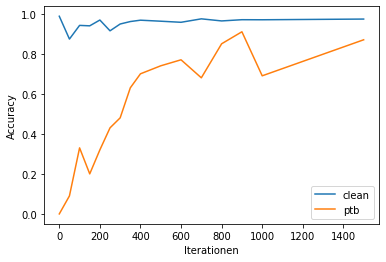

In [6]:



acc_clean_arr=[]
acc_ptb_arr=[]
acc_inv_arr=[]

i=0
for model in models:
    res=test_model(model)
    acc_clean_arr.append(res.get("clean").get("accuracy"))
    acc_ptb_arr.append(res.get("ptb").get("accuracy"))
    acc_inv_arr.append(res.get("inv").get("accuracy"))
    print(i)
    i+=1
plt.plot( y, acc_clean_arr, label = "clean")
plt.plot( y, acc_ptb_arr,label = "ptb")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Test Models

In [ ]:
def test_model(model):
    assert epsilon==0.3
    inv_advs_to_test=np.load("invariance_examples/linf/automated_eps03.npy")
    inv_labels_to_test=np.load("invariance_examples/linf/automated_eps03_labels.npy")
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
    attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)

    x_batch,y_batch=next_batch(100,x_train,y_train)
    x_batch_to_test = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    x_batch_to_test=x_batch_to_test[:,:,:,np.newaxis]
    y_batch_to_test=tf.convert_to_tensor(y_batch, dtype=tf.int32)
    _,advs_to_test, success=attack(fmodel,x_batch_to_test, y_batch_to_test, epsilons=epsilon)
  

    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    x=tf.keras.backend.get_value(advs_to_test)
    ptb_test=x[:, :, :, 0]

    #get accuracies and losses
    acc =model.evaluate(x_test,to_categorical(y_test), verbose=0)
    acc_ptb = model.evaluate(ptb_test,to_categorical(y_batch), verbose=0)
    acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)


    # get invariance adversarial examples success rate
    predictions=model.predict(inv_advs_to_test)
    disagreeing=0
    for i in range(len(predictions)):
        if inv_labels_to_test[i] !=np.argmax(predictions[i]):
            disagreeing+=1
              
    return {
    "clean":{"loss": acc[0], "accuracy":acc[1]},
    "ptb":{"loss": acc_ptb[0], "accuracy":acc_ptb[1]},
    "inv":{"loss": acc_inv[0], "accuracy":acc_inv[1]},
    "inv_success_rate":disagreeing/100}


vanilla_model=load_model("models/vanilla_model")
ptb_trained_model=load_model("models/ptb_trained_model_5000_iterations")

vanilla=test_model(vanilla_model)

ptb=test_model(ptb_trained_model)


print(vanilla)
print(ptb)